# Lesson 2: Baseline Email Assistant

This lesson builds an email assistant that:
- Classifies incoming messages (respond, ignore, notify)
- Drafts responses
- Schedules meetings

We'll start with a simple implementation - one that uses hard-coded rules to handle emails.

![Memory Course App](./img/memory_course_email.png)


## Load API tokens for our 3rd party APIs

In [1]:
import os
from dotenv import load_dotenv
_ = load_dotenv()

## Setup a Profile, Prompt and Example Email

In [2]:
profile = {
    "name": "John",
    "full_name": "John Doe",
    "user_profile_background": "Senior software engineer leading a team of 5 developers",
}

In [3]:
prompt_instructions = {
    "get_web_search_tool": {
        "ignore": "Marketing newsletters, spam emails, mass company announcements",
        "notify": "Team member out sick, build system notifications, project status updates",
        "respond": "Direct questions from team members, meeting requests, critical bug reports",
    },
    "agent_instructions": "Use these tools when appropriate to help manage John's tasks efficiently."
}

In [4]:
# Example incoming email
email = {
    "from": "Alice Smith <alice.smith@company.com>",
    "to": "John Doe <john.doe@company.com>",
    "subject": "Quick question about API documentation",
    "body": """
Hi John,

I was reviewing the API documentation for the new authentication service and noticed a few endpoints seem to be missing from the specs. Could you help clarify if this was intentional or if we should update the docs?

Specifically, I'm looking at:
- /auth/refresh
- /auth/validate

Thanks!
Alice""",
}

## Define the first part of the agent - triage.

In [5]:
from pydantic import BaseModel, Field
from typing_extensions import TypedDict, Literal, Annotated
from langchain.chat_models import init_chat_model

In [8]:
llm = init_chat_model("openai:gpt-4o-mini")

In [7]:
class Router(BaseModel):
    """Analyze the unread email and route it according to its content."""

    reasoning: str = Field(
        description="Step-by-step reasoning behind the classification."
    )
    classification: Literal["ignore", "respond", "notify"] = Field(
        description="The classification of an email: 'ignore' for irrelevant emails, "
        "'notify' for important information that doesn't need a response, "
        "'respond' for emails that need a reply",
    )

In [9]:
llm_router = llm.with_structured_output(Router)

In [10]:
from prompts import triage_system_prompt, triage_user_prompt

In [11]:
# uncomment to view
print(triage_system_prompt)
print(triage_user_prompt)


< Role >
You are {full_name}'s executive assistant. You are a top-notch executive assistant who cares about {name} performing as well as possible.
</ Role >

< Background >
{user_profile_background}. 
</ Background >

< Instructions >

{name} gets lots of emails. Your job is to categorize each email into one of three categories:

1. IGNORE - Emails that are not worth responding to or tracking
2. NOTIFY - Important information that {name} should know about but doesn't require a response
3. RESPOND - Emails that need a direct response from {name}

Classify the below email into one of these categories.

</ Instructions >

< Rules >
Emails that are not worth responding to:
{triage_no}

There are also other things that {name} should know about, but don't require an email response. For these, you should notify {name} (using the `notify` response). Examples of this include:
{triage_notify}

Emails that are worth responding to:
{triage_email}
</ Rules >

< Few shot examples >
{examples}
</ Fe

In [12]:
system_prompt = triage_system_prompt.format(
    full_name=profile["full_name"],
    name=profile["name"],
    examples=None,
    user_profile_background=profile["user_profile_background"],
    triage_no=prompt_instructions["triage_rules"]["ignore"],
    triage_notify=prompt_instructions["triage_rules"]["notify"],
    triage_email=prompt_instructions["triage_rules"]["respond"],
)

In [13]:
user_prompt = triage_user_prompt.format(
    author=email["from"],
    to=email["to"],
    subject=email["subject"],
    email_thread=email["body"],
)

In [14]:
result = llm_router.invoke(
    [
        {"role": "system", "content": system_prompt},
        {"role": "user", "content": user_prompt},
    ]
)

In [15]:
print(result)

reasoning="This email is a direct question from a team member (Alice) seeking clarification on a technical matter regarding API documentation. It requires John to provide feedback about whether the missing endpoints were intentional or if the documentation needs updating. Since it involves a specific inquiry that requires John's insight and response, it falls into the category of emails that need a direct response." classification='respond'


## Main agent, define tools

In [16]:
from langchain_core.tools import tool

In [17]:
@tool
def write_email(to: str, subject: str, content: str) -> str:
    """Write and send an email."""
    # Placeholder response - in real app would send email
    return f"Email sent to {to} with subject '{subject}'"

In [18]:
@tool
def schedule_meeting(
    attendees: list[str], 
    subject: str, 
    duration_minutes: int, 
    preferred_day: str
) -> str:
    """Schedule a calendar meeting."""
    # Placeholder response - in real app would check calendar and schedule
    return f"Meeting '{subject}' scheduled for {preferred_day} with {len(attendees)} attendees"



In [19]:
@tool
def check_calendar_availability(day: str) -> str:
    """Check calendar availability for a given day."""
    # Placeholder response - in real app would check actual calendar
    return f"Available times on {day}: 9:00 AM, 2:00 PM, 4:00 PM"

## Main agent, define prompt

In [20]:
from prompts import agent_system_prompt
def create_prompt(state):
    return [
        {
            "role": "system", 
            "content": agent_system_prompt.format(
                instructions=prompt_instructions["agent_instructions"],
                **profile
                )
        }
    ] + state['messages']

In [21]:
print(agent_system_prompt)


< Role >
You are {full_name}'s executive assistant. You are a top-notch executive assistant who cares about {name} performing as well as possible.
</ Role >

< Tools >
You have access to the following tools to help manage {name}'s communications and schedule:

1. write_email(to, subject, content) - Send emails to specified recipients
2. schedule_meeting(attendees, subject, duration_minutes, preferred_day) - Schedule calendar meetings
3. check_calendar_availability(day) - Check available time slots for a given day
</ Tools >

< Instructions >
{instructions}
</ Instructions >



In [22]:
from langgraph.prebuilt import create_react_agent

In [23]:
tools=[write_email, schedule_meeting, check_calendar_availability]

In [24]:
agent = create_react_agent(
    "openai:gpt-4o-mini",
    tools=tools,
    prompt=create_prompt,
)

In [25]:
response = agent.invoke(
    {"messages": [{
        "role": "user", 
        "content": "what is my availability for tuesday?"
    }]}
)

In [26]:
response["messages"][-1].pretty_print()

================================== Ai Message ==================================

You are available on Tuesday at the following times: 

- 9:00 AM
- 2:00 PM
- 4:00 PM


## Create the Overall Agent

In [27]:
from langgraph.graph import add_messages

class State(TypedDict):
    email_input: dict
    messages: Annotated[list, add_messages]

In [28]:
from langgraph.graph import StateGraph, START, END
from langgraph.types import Command
from typing import Literal
from IPython.display import Image, display

In [29]:
def triage_router(state: State) -> Command[
    Literal["response_agent", "__end__"]
]:
    author = state['email_input']['author']
    to = state['email_input']['to']
    subject = state['email_input']['subject']
    email_thread = state['email_input']['email_thread']

    system_prompt = triage_system_prompt.format(
        full_name=profile["full_name"],
        name=profile["name"],
        user_profile_background=profile["user_profile_background"],
        triage_no=prompt_instructions["triage_rules"]["ignore"],
        triage_notify=prompt_instructions["triage_rules"]["notify"],
        triage_email=prompt_instructions["triage_rules"]["respond"],
        examples=None
    )
    user_prompt = triage_user_prompt.format(
        author=author, 
        to=to, 
        subject=subject, 
        email_thread=email_thread
    )
    result = llm_router.invoke(
        [
            {"role": "system", "content": system_prompt},
            {"role": "user", "content": user_prompt},
        ]
    )
    if result.classification == "respond":
        print("📧 Classification: RESPOND - This email requires a response")
        goto = "response_agent"
        update = {
            "messages": [
                {
                    "role": "user",
                    "content": f"Respond to the email {state['email_input']}",
                }
            ]
        }
    elif result.classification == "ignore":
        print("🚫 Classification: IGNORE - This email can be safely ignored")
        update = None
        goto = END
    elif result.classification == "notify":
        # If real life, this would do something else
        print("🔔 Classification: NOTIFY - This email contains important information")
        update = None
        goto = END
    else:
        raise ValueError(f"Invalid classification: {result.classification}")
    return Command(goto=goto, update=update)

## Put it all together

In [30]:
email_agent = StateGraph(State)
email_agent = email_agent.add_node(triage_router)
email_agent = email_agent.add_node("response_agent", agent)
email_agent = email_agent.add_edge(START, "triage_router")
email_agent = email_agent.compile()

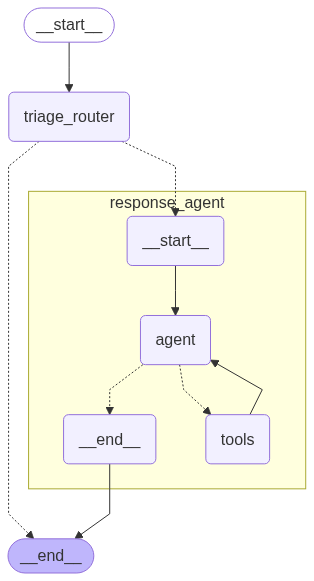

In [ ]:
# Show the agent
display(Image(email_agent.get_graph(xray=True).draw_mermaid_png()))

In [31]:
email_input = {
    "author": "Marketing Team <marketing@amazingdeals.com>",
    "to": "John Doe <john.doe@company.com>",
    "subject": "🔥 EXCLUSIVE OFFER: Limited Time Discount on Developer Tools! 🔥",
    "email_thread": """Dear Valued Developer,

Don't miss out on this INCREDIBLE opportunity! 

🚀 For a LIMITED TIME ONLY, get 80% OFF on our Premium Developer Suite! 

✨ FEATURES:
- Revolutionary AI-powered code completion
- Cloud-based development environment
- 24/7 customer support
- And much more!

💰 Regular Price: $999/month
🎉 YOUR SPECIAL PRICE: Just $199/month!

🕒 Hurry! This offer expires in:
24 HOURS ONLY!

Click here to claim your discount: https://amazingdeals.com/special-offer

Best regards,
Marketing Team
---
To unsubscribe, click here
""",
}

In [32]:
response = email_agent.invoke({"email_input": email_input})

🚫 Classification: IGNORE - This email can be safely ignored


In [46]:
email_input = {
    "author": "Alice Smith <alice.smith@company.com>",
    "to": "John Doe <john.doe@company.com>",
    "subject": "Quick question about API documentation",
    "email_thread": """Hi John,

I was reviewing the API documentation for the new authentication service and noticed a few endpoints seem to be missing from the specs. Could you help clarify if this was intentional or if we should update the docs?

Specifically, I'm looking at:
- /auth/refresh
- /auth/validate

Thanks!
Alice""",
}

In [ ]:
response = email_agent.invoke({"email_input": email_input})

📧 Classification: RESPOND - This email requires a response


In [48]:
for m in response["messages"]:
    m.pretty_print()

================================ Human Message =================================

Respond to the email {'author': 'Alice Smith <alice.smith@company.com>', 'to': 'John Doe <john.doe@company.com>', 'subject': 'Quick question about API documentation', 'email_thread': "Hi John,\n\nI was reviewing the API documentation for the new authentication service and noticed a few endpoints seem to be missing from the specs. Could you help clarify if this was intentional or if we should update the docs?\n\nSpecifically, I'm looking at:\n- /auth/refresh\n- /auth/validate\n\nThanks!\nAlice"}
================================== Ai Message ==================================
Tool Calls:
  write_email (call_KRJuculpHFk2vhcNfnRRWkV1)
 Call ID: call_KRJuculpHFk2vhcNfnRRWkV1
  Args:
    to: alice.smith@company.com
    subject: Re: Quick question about API documentation
    content: Hi Alice,

Thanks for reaching out about this. I appreciate your diligence in going through the API documentation.

The endpoints 